### Fine-tuning word embeddings for Iris.ai
See "resources/W2V model training.pdf" for problem definition

In [1]:
from collections import Counter
from copy import deepcopy
import itertools as it
import json
import pickle
import tempfile
import torch
import time

import gensim
from gensim.models import Word2Vec, KeyedVectors
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

from resources.pip_code_snippet import (
    make_fingerprint_matrix, calculate_pip_distance_of_arrays, calculate_pip_distance)
from utils import matrix_to_w2v, topn_overlap

In [2]:
with open('resources/ref_vocab_matrix.pkl', 'rb') as f:
    ref_vocab_matrix = pickle.load(f)
    
with open('resources/ref_vocab.json') as f:
    ref_vocab = json.load(f)
    
with open('resources/dataset.json') as f:
    dataset = json.load(f)

###  The PIP metric

Before optimizing a metric its worth testing its behavior in different situations. <br/>

Pairwise Inner Product (**PIP**) measures a distance between between two sets of word embeddings A and B by comparing the cosine similarity of
every word pair (w1, w2) in A versus in B.

Pros: <br/>
\- Invariant to unitary transforms such as rotation and simmetry  <br/>
\- Correctly identifies when embddings are almost completely identical

Cons: <br/>
\- Influenced by the global geometry of the embeddings, not relative positions of words <br/>
\- Can be a poor proxy for semantic similarity <br/>
\- Doesn't objectively measure embeddings quality, only compares them to another reference model </br>

**We'll only measure PIP relative to the ground truth ref_vocab_matrix.** <br/>

### Inspecting a minimal 2d  model
Let's see the relationship between 3 models: <br/>
1) Simple embeddigns of 6 words in 2d space (reference model) <br/>
2) Transformed version of 1) that keeps much of its structure <br/>
3) Random vectors with similar global geometry <br/>

In [3]:
vocab = ['a', 'b', 'c', 'A', 'B', 'C']
embeddings = np.array([
    [-2. , 14. ], [-1.5, 15.5], [-1. , 14. ],
    [ 1. , 16. ], [ 1.5, 17.5], [ 2. , 16. ],
])

transformed_embeddings = embeddings.copy()
transformed_embeddings[:, 0] *= 2.5
transformed_embeddings[:, 1] -= 10

random_embeddings = np.random.normal(0, 0.8, 12).reshape([6, 2])
random_embeddings[:,1] += 13.5

ref_model = matrix_to_w2v(embeddings, vocab)
transformed_model = matrix_to_w2v(transformed_embeddings, vocab)
random_model = matrix_to_w2v(random_embeddings, vocab)

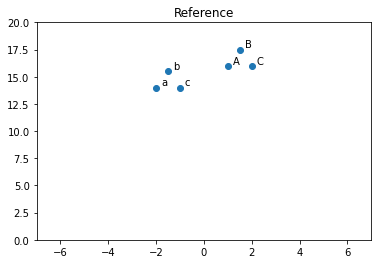

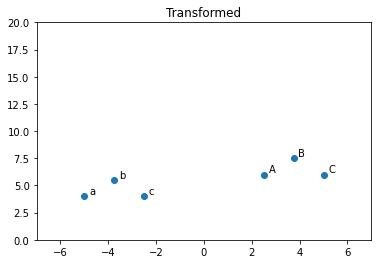

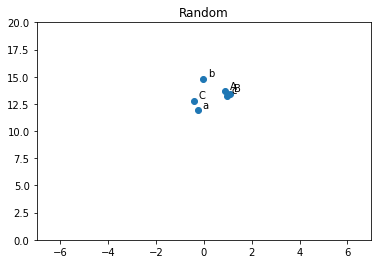

In [4]:
def plot_points(points, title=''):
    fig, ax = plt.subplots()
    plt.xlim((-7, 7)), plt.ylim((0, 20)), plt.title(title)
    ax.scatter(points[:,0], points[:,1])
    for i, word in enumerate(vocab):
        ax.annotate(word, (points[:,0][i] + 0.2, points[:,1][i] + 0.2))
    plt.show()
    
plot_points(embeddings, title='Reference')
plot_points(transformed_embeddings, title='Transformed')
plot_points(random_embeddings, title='Random')

As we see from the plot the transformed model preserves most of the structure (and thus information) from the reference one, and the last model is random by construction. <br/>
Here's the PIP metric scores:

In [5]:
print('PIP transformed:  {:.3f}\n'
      'PIP random:       {:.3f}'.format(
      calculate_pip_distance_of_arrays(embeddings, transformed_embeddings),
      calculate_pip_distance_of_arrays(embeddings, random_embeddings)))

PIP transformed:  0.481
PIP random:       0.116


##### PIP considers the random model similar to the reference one, and the transformed model  very different from the reference one.
This suggests that PIP is sensitive to the global geometry of the embeddings, like the average cos similarity between any two words. This is irrespective of the relative positions of words to one another, which is often the main information carrier in word embeddings

Using other metrics, like directly comparing word similarity or doing vector arithmetic, we can verify that **only the transformed model preserves any information**, as expected.

In [6]:
# Inspect most similar words

target_word = 'a'
print('Most similar to "{}", according to: \n'
      '  reference model  : {} \n'
      '  transformed model: {} \n'
      '  random model     : {}'.format(
        target_word,
        ref_model.most_similar(target_word, topn=3),
        transformed_model.most_similar(target_word, topn=3),
        random_model.most_similar(target_word, topn=3)))

Most similar to "a", according to: 
  reference model  : [('b', 0.9989684820175171), ('c', 0.9975096583366394), ('A', 0.979200005531311)] 
  transformed model: [('b', 0.9560322165489197), ('c', 0.943600058555603), ('A', 0.27630746364593506)] 
  random model     : [('C', 0.9999374151229858), ('b', 0.9998238682746887), ('A', 0.9964320659637451)]


In [7]:
# Try vector arithmetics

b_minus_a_plus_A = [
    m.similar_by_vector(
        (m.wv['b'] - m.wv['a'] + m.wv['A']))[0]
    for m in (ref_model, transformed_model, random_model)]

print('Embeddings of (b - a + A): \n\n'
      'reference model:   {} \n'
      'transformed model: {} \n'
      'random model:      {} \n'
      ''.format(*b_minus_a_plus_A))

Embeddings of (b - a + A): 

reference model:   ('B', 0.9999999403953552) 
transformed model: ('B', 0.9999999403953552) 
random model:      ('A', 0.9999980330467224) 



/home/danko/miniconda3/envs/gensim/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


## Baselines
We'll consider a few different models <br/>
\- A random model <br/>
\- Embeddings trained from scratch <br/>
\- mat2vec - word embeddings trained on material science literature [doi: 10.1038/s41586-019-1335-8, Tshitoyan et al. 2019] <br/>
\- mat2vec finetuned on the provided dataset <br/> <br/>
We can also keep track of the topn_overlap metric, which measures the average overlap in `model_1.most_similar(word)` and `model_2.most_similar(word)`

In [4]:
from utils import preprocess_dataset

corpus = preprocess_dataset(dataset)
ref_model = matrix_to_w2v(ref_vocab_matrix, ref_vocab)

In [5]:
d = 200
random_vectors = np.random.normal(0, 1, len(ref_vocab) * d).reshape((len(ref_vocab), d))
random_model = matrix_to_w2v(random_vectors, ref_vocab)

print('Random model\nPIP: {:.3f} \noverlap: {:.3f}'.format(
    calculate_pip_distance(ref_vocab, ref_vocab_matrix, random_model),
    topn_overlap(ref_model, random_model, ref_vocab)))

Random model
PIP: 0.364 
overlap: 0.053


In [6]:
model_from_scratch = Word2Vec(
    corpus + [ref_vocab] * 3,
    size=200, window=13, min_count=3, workers=4)
model_from_scratch.train(corpus, total_examples=len(corpus), epochs=3)

print('Model_from_scratch\nPIP: {:.3f} \noverlap: {:.3f}'.format(
    calculate_pip_distance(ref_vocab, ref_vocab_matrix, model_from_scratch),
    topn_overlap(ref_model, model_from_scratch, ref_vocab)))

Model_from_scratch
PIP: 0.274 
overlap: 0.331


In [7]:
model_path = 'mat2vec/pretrained_embeddings'
mat2vec = Word2Vec.load(model_path)

print('mat2vec\nPIP: {:.3f} \noverlap: {:.3f}'.format(
    calculate_pip_distance(ref_vocab, ref_vocab_matrix, mat2vec),
    topn_overlap(ref_model, mat2vec, ref_vocab)))

mat2vec
PIP: 0.232 
overlap: 0.375


In [16]:
model_path = 'mat2vec/pretrained_embeddings'
mat2vec_finetuned = Word2Vec.load(model_path)
mat2vec_finetuned.build_vocab(sentences=corpus + [ref_vocab]*5, update=True)
mat2vec_finetuned = Word2Vec.load(model_path)
mat2vec_finetuned.train(corpus, total_examples=len(corpus), epochs=3)

print('Finetuned mat2vec\nPIP: {:.3f} \noverlap: {:.3f}'.format(
    calculate_pip_distance(ref_vocab, matrix, mat2vec),
    topn_overlap(ref_model, model_from_scratch, ref_vocab)))

Finetuned mat2vec
PIP: 0.266 
overlap: 0.345


#### It's worth noting that mat2vec is a very strong baseline, having sensible domain-specific predictions out of the box, which are similar to the reference ones, as seen below.

In [48]:
# Displaying similarity to words only in the ref_vocab

target_word = 'ferrite'
similar = mat2vec.most_similar(target_word, topn=10000)
print('Words most similar to "{}" in:'.format(target_word))
print('mat2vec:  ', [s[0] for s in similar if s[0] in ref_vocab][:6])
print('ref_model:', [w for w, s in ref_model.most_similar(target_word, topn=6)])

Words most similar to "ferrite" in:
mat2vec:   ['austenite', 'pearlite', 'martensite', 'bainite', 'martensitic', 'carbide']
ref_model: ['martensite', 'bainite', 'pearlite', 'microstructure', 'carbide', 'austenite']


/home/danko/miniconda3/envs/gensim/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


### Optimizing PIP
Let's consider in what conditions PIP will give falsely optimistic or pesimistic evaluation of embeddings. <br/>
<br/>
We can check how far we can reduce PIP by stretching the embedding space of a random model (thus modifying the average cos between vectors). <br/>
Note that we'll apply **the same transform to every vector** so the relative word positions remain random.

For a vector *v*, lets define a transform, parametrized by vectors p, w, b: <br/>
T(v) = (v\*\*p) * w + b <br/>
This a little more than a linear transform with 'p' adding a slight curvature (although a purely linear transform will have almost the same effect)
This transformation is differentiable so we can easily optimize it.

In [17]:
dim = 100
random_vectors = np.random.normal(0, 1, len(ref_vocab) * dim).reshape((len(ref_vocab), dim))
random_model = matrix_to_w2v(random_vectors, ref_vocab)

In [18]:
print('PIP of random model: {:.3f}'.format(
        calculate_pip_distance(ref_vocab, ref_vocab_matrix, random_model)))

PIP of random model: 0.372


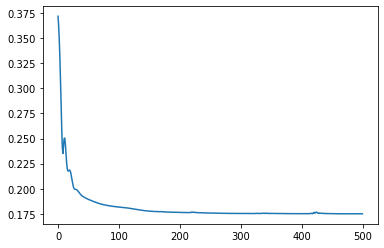

PIP after transform: 0.175


In [19]:
from optimize_global_geometry import optimize_global_geometry

_, transform, pip_vals = optimize_global_geometry(random_vectors, ref_vocab_matrix)

plt.plot(pip_vals)
plt.show()
print('PIP after transform: {:.3f}'.format(np.mean(pip_vals[-10:])))

Let's inspect the effect of dimensionality on the metric.

In [21]:
for dim in [20, 200, 2000, 20000, 200000]:
    random_vectors = np.random.normal(0, 1, len(ref_vocab) * dim).reshape((len(ref_vocab), dim))
    random_model = matrix_to_w2v(random_vectors, ref_vocab)

    params, transform, pip_vals = optimize_global_geometry(random_vectors, ref_vocab_matrix)
    print('PIP after transform (dim={}): {:.3f}'.format(dim, np.mean(pip_vals[-10:])))

PIP after transform (dim=20): 0.260
PIP after transform (dim=200): 0.161
PIP after transform (dim=2000): 0.120
PIP after transform (dim=20000): 0.100
PIP after transform (dim=200000): 0.082


The last model has PIP multiple times lower than that of mat2vec and has dimensionality of 200 000, which seems unreasonably high. <br/>
Note that so far we are **NOT** overfitting the ref_matrix, in fact we are not even it fitting the slightest. The relative positions of word vectors are random and the top_n similarity still doesn't overlap with the ref model's better than random.

In [12]:
transformed_matrix = transform(torch.tensor(random_vectors).cuda())
transformed_model = matrix_to_w2v(transformed_matrix, ref_vocab)

print('Transformed model topn overlap: {:.3f}'.format(
    topn_overlap(ref_model, transformed_model, ref_vocab)))

Transformed model topn overlap: 0.095


During training of embeddings, normally we don't manually control the subset of the space which we want the embeddings to occupy. If we try to pick hyperparameters that diractly minimize PIP, we'll probably end up with the ones that accidentally happen to be closest to the global geomtry of the ref model, wether or not they fit the dataset well, since its effect is so large. <br/>

Clearly, further improvements from the ones we achieved with the random model can happen if the actual word relations begin to match the ground truth model. <br/>

The next thing we can try is training a model, then optimizing its global geometry, and seeing how much the PIP improves over the random baseline. This way, we can compare models only "in their best shape", ignoring the random aspects of the global structure that arise at train time. Therefore, we may attribute any improvements to the meaningful similarities in the embeddings. <br/>

However, for this to be a valid approach, we need to know that fitting PIP with respect to the ref_model will translate to all other words. <br/>
We can check this by doing cross-validation on our ref_matrix

In [13]:
# 2-fold cross-validation split for simplicity
# We want to track if the validation results are correlated in both directions
def cross_validate_geom_optim(vectors, ref_vocab_matrix):
    split = ref_vocab_matrix.shape[0] // 2
    _, transform, pip_vals = optimize_global_geometry(vectors[:split], ref_vocab_matrix[:split])
    transformed_matrix = transform(torch.tensor(vectors).cuda())
    train_1 = np.mean(pip_vals[-10:])
    val_1 = calculate_pip_distance_of_arrays(
        ref_vocab_matrix[split:], transformed_matrix[split:].detach().cpu().numpy())
    
    _, transform, pip_vals = optimize_global_geometry(vectors[split:], ref_vocab_matrix[split:])
    transformed_matrix = transform(torch.tensor(vectors).cuda())
    train_2 = np.mean(pip_vals[-10:])
    val_2 = calculate_pip_distance_of_arrays(
        ref_vocab_matrix[:split], transformed_matrix[:split].detach().cpu().numpy())
    
    return train_1, train_2, val_1, val_2

We'll try both a random and a train model to see if the PIP values translate to validation dataset for any dimensionality of the embeddings.
For simplicity, we'll simply split the reference matrix to two equal parts for train and validation

In [116]:
# Cross-validate random model with different dimensionality of the model

dims = [20, 50, 100, 200, 500, 1000, 2000]
trains_1, trains_2, vals_1, vals_2 = [], [], [], []
for dim in dims:
    random_vectors = np.random.normal(0, 1, len(ref_vocab) * dim).reshape((len(ref_vocab), dim))
    t1, t2, v1, v2 = cross_validate_geom_optim(random_vectors, ref_vocab_matrix)
    trains_1.append(t1)
    trains_2.append(t2)
    vals_1.append(v1)
    vals_2.append(v2)

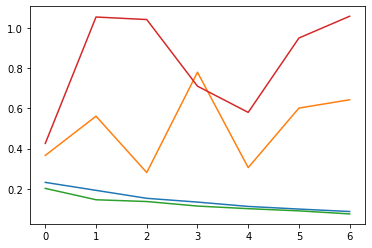

In [117]:
plt.plot(trains_1)
plt.plot(trains_2)
plt.plot(vals_1)
plt.plot(vals_2)

Running this multiple times, we don't see clear correlation between dimensionality and validation performance.

164.7999620437622


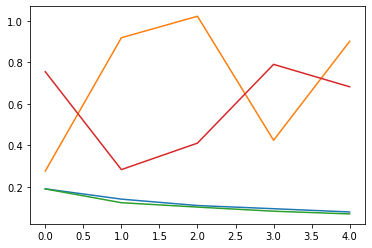

In [183]:
# Cross-validate model train from scratch with different dimensions

dims = [20, 50, 100, 200, 500]
trains_1, trains_2, vals_1, vals_2 = [], [], [], []
overlaps = []
for dim in dims:
    window, min_count = 13, 3
    model_from_scratch = Word2Vec(
        corpus +
        [ref_vocab] * min_count,
        size=dim, window=window, min_count=min_count, workers=4)
    model_from_scratch.train(corpus, total_examples=len(corpus), epochs=3)  # train
    vectors = np.array([model_from_scratch.wv[w] for w in ref_vocab])
    
    t1, t2, v1, v2 = cross_validate_geom_optim(vectors, ref_vocab_matrix)
    trains_1.append(t1)
    trains_2.append(t2)
    vals_1.append(v1)
    vals_2.append(v2)
    overlaps.append(topn_overlap(model_from_scratch, ref_model, ref_vocab))

plt.plot(trains_1)
plt.plot(trains_2)
plt.plot(vals_1)
plt.plot(vals_2)

Again, there's no clear evidence evidence that the dimensionality correlates with the validation pip or with the topn_overlap metric.

So far it looks like (at least for a ref_matrix of the given size): <br/>
\- fitting the global geometry of the embedding to a small ref matrix doesn't consistently translate to low pip on the validation part of the matrix  <br/>
\- not fitting the global geometry to the ref matrix yields results that can be outperformed by random noise, making the metric unreliable <br/>
\- the chosen metric doesn't always correlate with other, more straightforward ways to compare embeddings, like top_n similarity overlap (again because of the random model achieving pip much lower than mat2vec)

Despite all these caveats, we can still try picking hyperparameters that perform best on the validation set. However, depending on the downstream task, it won't be surprising if the resulting model is outperformed by the raw mat2vec baseline or its simplest finetuned version without modifications.

In [50]:
import optunity

def target_fn(size, window, min_count):
    size, window, min_count = int(size), int(window), int(min_count)
    model = Word2Vec(
        corpus + [ref_vocab] * min_count,
        size=size, window=window, min_count=min_count, workers=2)
    model.train(corpus, total_examples=len(corpus), epochs=3)
    vectors = np.array([model.wv[w] for w in ref_vocab])
    _, _, v1, v2 = cross_validate_geom_optim(vectors, ref_vocab_matrix)
    return (v1 + v2) / 2

logs = {}
solver = 'particle swarm'
pars, details, _ = optunity.minimize(
    target_fn, num_evals=100,
    size=[20, 2000],
    window=[3, 30],
    min_count=[1, 20],
    solver_name=solver)
logs = np.array([details.call_log['args']['size'],
                 details.call_log['args']['window'],
                 details.call_log['args']['min_count']])

In [51]:
# best pip found:
details.optimum

0.2313166515841633
